In [1]:
'''Flickr 30k Grounding with PyTorch.'''
from FlickrDataset2 import FlickrDataset2
from tensorboardX import SummaryWriter
from __future__ import print_function
import matplotlib.patches as patches
from torch.autograd import Variable
from torchvision import transforms
from skimage.morphology import *
import matplotlib.pyplot as plt
from Model2 import Model2
from net_util import *
from parser import *
import statistics
import math
import cv2
%matplotlib inline  
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
def retrieve_bboxes(att_map, bboxes):
    # compute the mean value of attention map
    mean = np.mean(att_map)
    # transform to 0-255 scale image
    test = (att_map * 255).astype('uint8')
    # threshold set to 3 times of mean value
    ret,thresh = cv2.threshold(test,round(mean*3*255), 255, 0)
    # contour detection
    im2, cts, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    contours = []
    # storing all countors and exlude area less then 4 pixels
    for i in range(0,len(cts)): 
        x, y, w, h = cv2.boundingRect(cts[i]) 
        # expanding the detected region to 120% for sub-window search
        x -= 0.4*w
        y -= 0.4*h
        w += .8*w
        h += .8*h
        if w>2 and h>2:
            contours.append(np.clip([round(x), round(y), round(x+w), round(y+h)], 0, att_map.shape[0]))
    # selecting all bboxes inside the contours
    # instead of picking bboxes out, we store the desired bboxes index
    target = np.zeros(500,)
    feat_bboxes = []
    count = 0
    num_boxes = 0
    # selected boxes index
    print(contours)
    target = np.zeros(bboxes.shape[0],)
    for box in bboxes:
#         resized_box = box/(256/att_map.shape[0])
        x_min, y_min, x_max, y_max = box.cpu().data.numpy()
        for contour in contours:
            contour2 = contour * (1024/att_map.shape[0])
            # check if box is inside the contour
#             print(x_min, y_min, w, h)
            if x_min >= contour2[0] and y_min >= contour2[1] and x_max <= contour2[2] and y_max <= contour2[3]:
                target[count] = 1
                num_boxes += 1
                break
        count += 1
    return target, num_boxes

def margin_loss(visual_feat, text_feat, label, margin=0.1):
    # Margin loss compute the loss as follows:
    # label: 0 or 1; v, t: target features; margin: minimum range between negative features
    # Loss = y(v-t)^2 + (1-y)(margin - ||v-t||)
    diff = visual_feat - text_feat
    dist = (torch.mul(diff, diff).sum(1) / visual_feat.shape[1]).sqrt()
    zero = Variable(torch.from_numpy(np.zeros(1))).cuda().float()
#     loss = label*dist + (1 - label)*torch.max(zero, margin - dist)
    loss = label*dist
    return loss.sum(0)/loss.shape[0]

def non_max_suppression_fast(boxes, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
 
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
 
	# initialize the list of picked indexes	
	pick = []
 
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]
	y2 = boxes[:,3]
 
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
 
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
 
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
 
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
 
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
 
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int")

In [4]:
# Load Pretrained Model.
class opts():
    backbone_model = './models/mrcnn.pth'
    class_num = 81
    batch_size = 64
    resume = './checkpoint/Model2_flickr_P3-P4-P5_att.pth'

    
opts = opts()
model = Model2(opts)
# Load Back bone Module
state_dict = torch.load(opts.resume)['state_dict']
new_params = model.state_dict()
new_params.update(state_dict)
model.load_state_dict(new_params)
model.cuda()
model.eval()
print('Model loaded')

==> Building backbone model...
Model loaded


In [5]:
# Load dataset and images
print("Preparing Flickr data set...")
size = (1024, 1024)
feat_size = (64, 64)
transform = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
data_set = FlickrDataset2('/media/drive1/Data/flickr30k/flickr30k_images/', feat_size, transform)
data_loader = torch.utils.data.DataLoader(data_set, batch_size=1,shuffle=False)

Preparing Flickr data set...
Loading dictionary...
Dictionary loaded.


/media/drive1/flickr_unsupervised_grounding_cocobased/FlickrDataset2.py:77: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if ran not in attributes:


53
a cold drink
[array([10, 45, 18, 53]), array([ 7, 29, 24, 46]), array([17, 15, 43, 64]), array([ 9, 12, 22, 26])]
[/EN#158651/people Man] atop [/EN#158655/other bike pole] sitting on [/EN#158652/vehicles bike] having [/EN#158653/other a cold drink] .


/media/drive1/flickr_unsupervised_grounding_cocobased/Model2.py:152: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  visual_cls = self.softmax(self.fc(visual_feat))


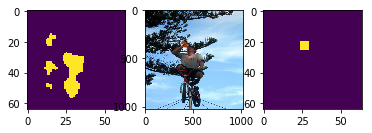

In [17]:
# attention map
# 7341: multi-person interesting image
(img, category, (one_hot, label), textual_emb, phrase, mask, line, filename, size, all_one_hot, att_emb, att_label, ent_att_lable) = data_set[1954]

model.visual_net.config.IMAGES_PER_GPU = 1

images = Variable(img.view(1, 3, 1024, 1024)).cuda()
# One-hot input
one_hot = Variable(torch.from_numpy(one_hot.reshape(1,-1))).cuda().float()
# one_hot = np.zeros((1, 81))
# one_hot[0] = 1
# one_hot = Variable(torch.from_numpy(one_hot)).cuda().float()
att_emb = torch.from_numpy(att_emb)
att_emb = Variable(att_emb.view(att_emb.shape[0],att_emb.shape[1]).float()).cuda()
model.visual_net.config.IMAGES_PER_GPU = 1
category_p3, att_map3, category_p4, att_map4, category_p5, att_map5, rpn_rois, visual_cls = model(images, one_hot, att_emb)

print(label)
plt.subplot(131)
plt.imshow(att_map5[0,0].data>0.3)
plt.subplot(132)
plt.imshow(img.permute(1,2,0).float().cpu())
plt.subplot(133)
plt.imshow(mask)
print(phrase)
att = att_map5[0,0].data.cpu().numpy()

# retriev all possible sub-boxes
target, num_boxes = retrieve_bboxes(att>0.3, rpn_rois[0])
print(line)

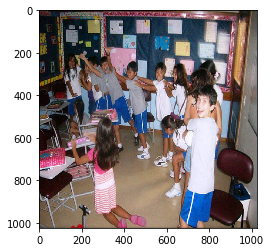

In [16]:
fig,ax = plt.subplots(1)
count = 0
target_box = []
for box in rpn_rois[0]:
    if target[count] == 1.:
        x1, y1, x2, y2 = box.cpu().data.numpy()
#         if (y2-y1)*(x2-x1) > 104857:
        target_box.append(box.cpu().data.numpy())
        rect = patches.Rectangle((round(x1), round(y1)), round(x2-x1), round(y2-y1), linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
    count += 1
# rect = patches.Rectangle((round(mx1), round(my1)), round(mx2-mx1), round(my2-my1), linewidth=1,edgecolor='r',facecolor='none')
# ax.add_patch(rect)
ax.imshow(img.permute(1,2,0).float().cpu())

In [8]:
# boxes = non_max_suppression_fast(np.asarray(target_box), 0.9)
# fig,ax = plt.subplots(1)
# count = 0
# target_box2= []
# for box in boxes:
#     if target[count] == 1.:
#         x1, y1, x2, y2 = box
# #         if (y2-y1)*(x2-x1) > 14857:
#         target_box2.append(box)
#         rect = patches.Rectangle((round(x1), round(y1)), round(x2-x1), round(y2-y1), linewidth=1,edgecolor='r',facecolor='none')
#         ax.add_patch(rect)
#     count += 1
# # rect = patches.Rectangle((round(mx1), round(my1)), round(mx2-mx1), round(my2-my1), linewidth=1,edgecolor='r',facecolor='none')
# # ax.add_patch(rect)
# ax.imshow(img.permute(1,2,0).float().cpu())

In [7]:
line

'[/EN#231549/people A girl] playing with [/EN#231550/other toys] .'

In [11]:
# Specific word testing
data_set.embeddings_index['women']
emb = np.zeros((1, 300))
emb[0] = data_set.embeddings_index['women']
emb = Variable(torch.from_numpy(emb)).cuda().float()

In [27]:
# Attribute embedding net scoring

# Generating possible testing masks
size = (64, 64)
count=0
min_score = 1
selected_box = np.zeros(size)
loss_box = {}
for box in target_box:
    p_mask = np.zeros(size)
#     x1, y1, x2, y2 = box.cpu().data.numpy()/(1024/128)
    x1, y1, x2, y2 = box/(1024/64)
    for x in range(p_mask.shape[0]):
        for y in range(p_mask.shape[1]):
            if x1<x<x2 and y1<y<y2:
                p_mask[y, x] = 1
    vp_mask = Variable(torch.from_numpy(p_mask)).float().cuda()
    v_feat, t_feat = model.ae_net(P3, P5, vp_mask, emb)
    index = 0
#     for item in att_label:
#         if item == 1.:
#             diff = v_feat[index] - t_feat[index]
#             dist = (torch.mul(diff, diff).sum(0))/1024
#             loss += dist
#         index += 1
    loss = margin_loss(v_feat, t_feat, att_label)
    
    loss = loss.sum(0)/loss.shape[0]
#     print(min_score)
    loss_box[loss[0].data.cpu().numpy()[0]] = p_mask
    if loss < min_score:
        min_score = loss
        selected_box = p_mask
    print(count)
    count += 1
    



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126


1
A man
[/EN#277879/people A man] wearing [/EN#277880/clothing a backwards baseball cap] .


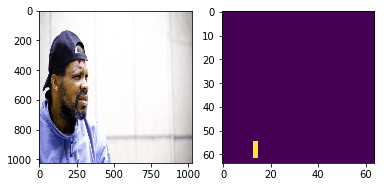

In [35]:
print(label)
plt.subplot(121)
plt.imshow(img.permute(1,2,0).float().cpu())
plt.subplot(122)
plt.imshow(selected_box)

print(phrase)
att = att_map[0,0].data.cpu().numpy()

# retriev all possible sub-boxes
print(line)

14


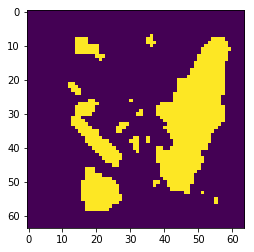

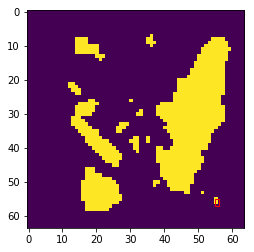

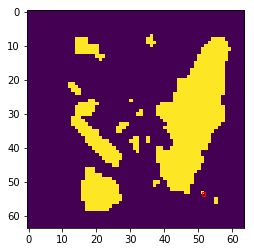

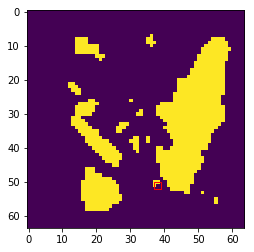

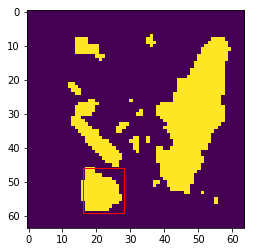

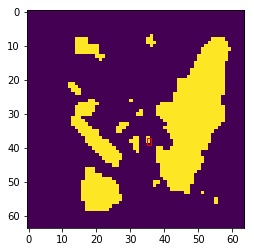

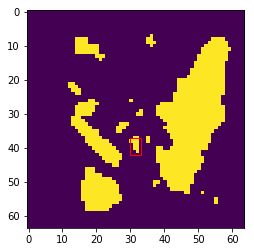

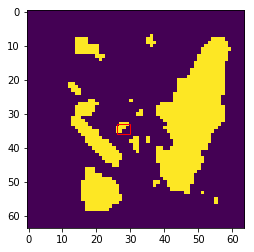

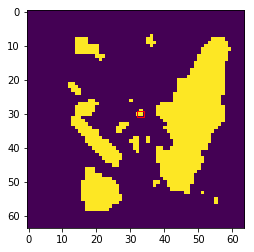

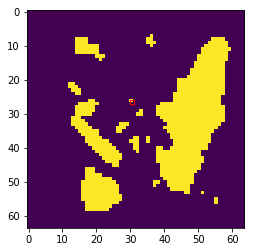

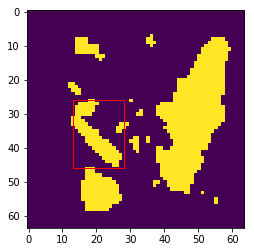

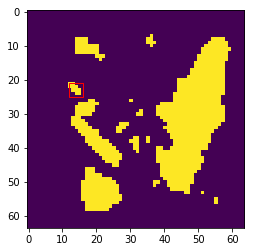

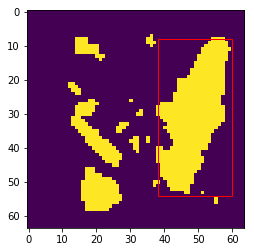

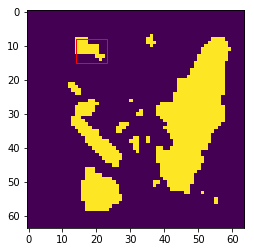

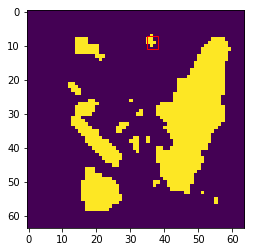

In [12]:
att = att>0.3
mean = np.mean(att)
fig1,ax1 = plt.subplots(1)
test = (att * 255).astype('uint8')
ax1.imshow(test)
ret,thresh = cv2.threshold(test,round(mean*3*255), 255, 0)
im2, cts, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print(len(cts)) 

for i in range(0,len(cts)): 
    x, y, w, h = cv2.boundingRect(cts[i])  
#     if w < 2 or h <2:
#         break
    fig,ax = plt.subplots(1)
    ax.imshow(test)
    rect = patches.Rectangle((x, y),w, h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)


7


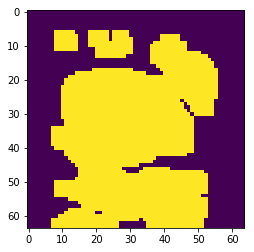

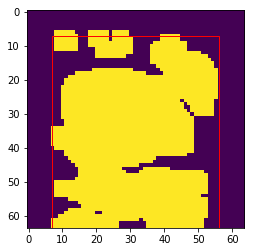

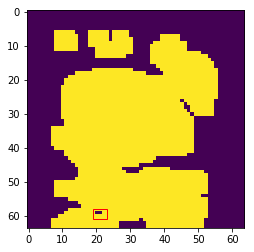

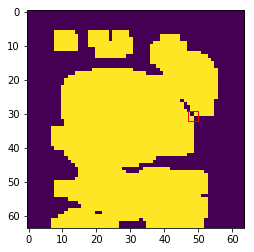

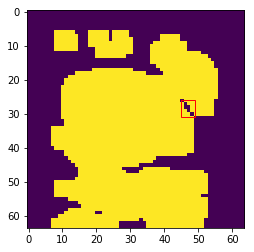

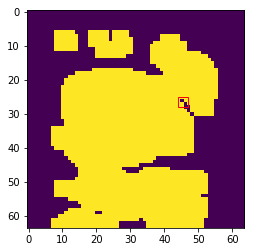

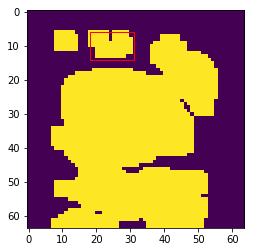

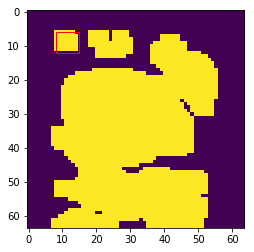

In [33]:
kernel = np.ones((5, 5),np.uint8)
test2 = cv2.dilate(test,kernel,iterations = 1)
plt.imshow(test2)
kernel = np.ones((5, 5),np.uint8)
opening = cv2.morphologyEx(test2, cv2.MORPH_OPEN, kernel)
ret,thresh = cv2.threshold(opening,round(mean*3*255), 255, 0)
im2, cts, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
print(len(cts)) 

for i in range(0,len(cts)): 
    x, y, w, h = cv2.boundingRect(cts[i])  
#     if w < 2 or h <2:
#         break
    fig,ax = plt.subplots(1)
    ax.imshow(opening)
    rect = patches.Rectangle((x, y),w, h,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
